# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

***Описание данных:***

Данные геологоразведки трёх регионов находятся в файлах:

`/datasets/geo_data_0.csv`

`/datasets/geo_data_1.csv`

`/datasets/geo_data_2.csv`

* `id` — уникальный идентификатор скважины;
* `f0, f1, f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
* `product` — объём запасов в скважине (тыс. баррелей).

## Загрузка и подготовка данных

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:90% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set();

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

In [3]:
RANDOM_SEED = 0

In [4]:
df_0 = pd.read_csv('../datasets/geo_data_0_7ds.csv')
df_1 = pd.read_csv('../datasets/geo_data_1_7ds.csv')
df_2 = pd.read_csv('../datasets/geo_data_2_7ds.csv')

In [5]:
show_sample = lambda x: display(x.sample(5, random_state=RANDOM_SEED).reset_index(drop=True))

In [6]:
show_sample(df_0)
show_sample(df_1)
show_sample(df_2)

,id,f0,f1,f2,product
0,zMatX,0.881376,0.273600,2.770651,49.723143
1,muBEx,-0.991020,0.010620,3.233630,10.583795
2,DMAPr,-0.987623,0.017871,5.005426,139.110613
3,fasrx,2.081966,0.426730,2.638579,85.109875
4,0XaIy,0.850498,0.473509,3.575604,39.726827


,id,f0,f1,f2,product
0,gnvG6,13.682535,-1.577749,4.999462,134.766305
1,KGfJ0,-4.834251,-0.349029,4.996602,137.945408
2,Km7yX,-7.287642,-4.184750,0.001329,3.179103
3,bGQtv,-10.041103,-16.919151,3.999895,110.992147
4,CuYNo,-8.650003,-4.526214,5.012777,137.945408


,id,f0,f1,f2,product
0,GdnWX,-0.838132,-0.968042,4.074363,129.102262
1,z2rQ2,0.370981,-0.573846,-3.568113,61.285744
2,vZROH,0.856767,1.441619,4.895820,65.026246
3,6AgeD,1.989628,-1.343347,3.242798,62.334048
4,nXQ8W,2.194257,-2.180922,1.699123,150.002134


In [7]:
print('Размер датасета df_0:', df_0.shape)
print('Размер датасета df_1:', df_1.shape)
print('Размер датасета df_2:', df_2.shape)

Размер датасета df_0: (100000, 5)
Размер датасета df_1: (100000, 5)
Размер датасета df_2: (100000, 5)


Размеры трех таблиц одинаковые. 

In [8]:
print(df_0.info(memory_usage=True))
print('----------------------------')
print(df_1.info(memory_usage=True))
print('----------------------------')
print(df_2.info(memory_usage=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries

Видим, что разрядность слишком высокая для хранения наших данных. Поэтому мы можем оптимизировать типы данных и ускорить работу кода.  Почти все поля типа `float`  за исключением `id`.

In [9]:
float_features = df_0.select_dtypes(include='float').columns

df_0[float_features] = df_0[float_features].apply(pd.to_numeric, downcast='float')
df_1[float_features] = df_1[float_features].apply(pd.to_numeric, downcast='float')
df_2[float_features] = df_2[float_features].apply(pd.to_numeric, downcast='float')

In [10]:
print(df_0.info(memory_usage=True))
print('----------------------------')
print(df_1.info(memory_usage=True))
print('----------------------------')
print(df_2.info(memory_usage=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float32
 2   f1       100000 non-null  float32
 3   f2       100000 non-null  float32
 4   product  100000 non-null  float32
dtypes: float32(4), object(1)
memory usage: 2.3+ MB
None
----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float32
 2   f1       100000 non-null  float32
 3   f2       100000 non-null  float32
 4   product  100000 non-null  float32
dtypes: float32(4), object(1)
memory usage: 2.3+ MB
None
----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries

Место немного сэкономили :) Пропусков в данных нет, это и так видно. Проверим наличие дубликатов.

In [11]:
print('Наличие дубликатов в df_0:', df_0.duplicated().sum())
print('Наличие дубликатов в df_1:', df_1.duplicated().sum())
print('Наличие дубликатов в df_2:', df_2.duplicated().sum())

Наличие дубликатов в df_0: 0
Наличие дубликатов в df_1: 0
Наличие дубликатов в df_2: 0


Дубликатов нет.

Посмотрим распределения фичей и таргета для всех регионов.

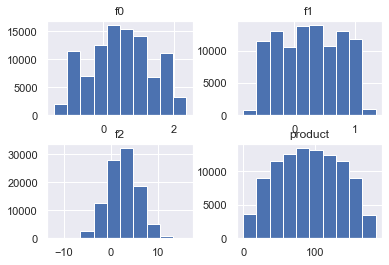

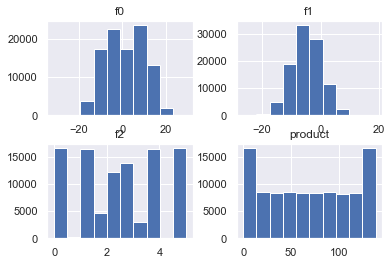

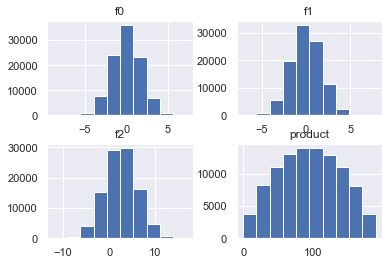

In [12]:
df_range = [df_0, df_1, df_2]
for df in df_range:
    df[float_features].hist();
    plt.show()


Построим корреляционные матрицы для всеех регионов.

In [19]:
corr_matrix_df_0 = df_0.corr()
corr_matrix_df_1 = df_1.corr()
corr_matrix_df_2 = df_2.corr()

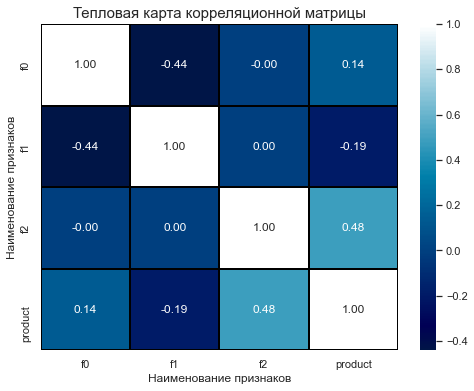

In [26]:
plt.figure(figsize = (8, 6))

plt.title('Тепловая карта корреляционной матрицы', size = 15)
sns_plot = sns.heatmap(corr_matrix_df_0, annot=True, fmt='.2f', 
                      linewidth=1, linecolor='black', vmax=1, center=0, cmap='ocean')
fig = sns_plot.get_figure()
plt.xlabel('Наименование признаков')
plt.ylabel('Наименование признаков')
plt.show()


In [27]:
#https://www.askpython.com/python/examples/heatmaps-in-python

In [13]:
#https://stackoverflow.com/questions/19614400/add-title-to-collection-of-pandas-hist-plots

Почти по всем распределениям из датасета `df_1` видим, что они отличаются от нормального, у `f0`, `f2` и `product` видим несколько пиков. В то время как распределение фичей и таргета в датасетах `df_0` и `df_2`  симметричны.

### Выводы

* Размеры всех трех датасетов одинаковые - 100000 строк и 5 столбцов.
* У них одинаковые поля
* Пропусков нет
* Дубликатов нет
* Оптимизировали типы данных для экономии памяти
* Почти по всем распределениям из датасета `df_1` видим, что они отличаются от нормального, у `f0`, `f2` и `product` видим несколько пиков. В то время как распределение фичей и таргета в датасетах `df_0` и `df_2`  симметричны.

## Обучение и проверка модели для каждого региона

### Обучение и проверка модели (c разбивкой данных на обучающую и валидационную выборки в соотношении 75:25)

In [14]:
def split_train_pred(data):
    '''
    split_train_pred - функция  разбивает выборки на обучающую и валидационную, масштабирует признаки, 
    строит модель линейной регрессии
    Input: data - таблица с данными
    Output: predictions, rmse, r2
    '''
    features = data.drop(['product', 'id'], axis=1)
    target = data['product']
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=RANDOM_SEED)
    
    scaler = StandardScaler()
    features_train = scaler.fit_transform(features_train)
    features_valid = scaler.fit_transform(features_valid)

    model = LinearRegression(normalize=False)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    predictions = pd.Series(predictions)
    
    rmse = (mean_squared_error(predictions, target_valid))**(0.5)
    average_prod = sum(predictions) / len(predictions)
    r2 = r2_score(target_valid, predictions)
    
    print("RMSE: {:.2f}".format(rmse))
    print("Средний запас предсказанного сырья: {:.2f}".format(average_prod))
    print("Коэффициент детерминации: {:.2f}".format(r2))
    
    return (predictions, target_valid.reset_index(drop=True), rmse, r2)

In [15]:
# Based on: https://stackoverflow.com/a/17303428 (для красивого оформления результата z-теста)
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [16]:
i=0
for region in df_range:
    print(color.UNDERLINE + "Регион " + str(i) + color.END)
    split_train_pred(region)
    i+=1
    print("__________________________________________\n\n")

Регион 0
RMSE: 37.48
Средний запас предсказанного сырья: 92.51
Коэффициент детерминации: 0.28
__________________________________________


Регион 1
RMSE: 0.99
Средний запас предсказанного сырья: 68.72
Коэффициент детерминации: 1.00
__________________________________________


Регион 2
RMSE: 40.31
Средний запас предсказанного сырья: 94.84
Коэффициент детерминации: 0.19
__________________________________________




Судя по среднему запасу предсказанного сырья можно сказать, что наиболее прибыльный регион - второй. **RMSE** - это среднеквадратичная ошибка (измеряет среднеквадратичную ошибку наших прогнозов). Чем выше это значение, тем хуже модель. Соответственно, среди всех регионов RMSE хуже всех тоже у второго региона, из чего следует, что требуется дальнейшее исследование. Коэффициент детерминации у региона 0 и региона 1 слишком низкий, что свидетельствует о слабой предсказательной силе нашей модели.

## Подготовка к расчёту прибыли

**Вводные для расчета прибыли**

- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.

- Бюджет на разработку скважин в регионе — 10 млрд рублей.

- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

In [18]:
BUDGET = 10000000000
RESEARCH_POINT = 500
BEST_POINT = 200
INCOME_PER_BARREL = 450
INCOME_PER_PRODUCT = 450000

## Расчёт прибыли и рисков 

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [ ]  Выполнен шаг 2: модели обучены и проверены
    - [ ]  Данные корректно разбиты на обучающую и валидационную выборки
    - [ ]  Модели обучены, предсказания сделаны
    - [ ]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [ ]  На экране напечатаны результаты
    - [ ]  Сделаны выводы
- [ ]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [ ]  Для всех ключевых значений созданы константы Python
    - [ ]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [ ]  По предыдущему пункту сделаны выводы
    - [ ]  Написана функция расчёта прибыли
- [ ]  Выполнен шаг 4: посчитаны риски и прибыль
    - [ ]  Проведена процедура *Bootstrap*
    - [ ]  Все параметры бутстрепа соответствуют условию
    - [ ]  Найдены все нужные величины
    - [ ]  Предложен регион для разработки месторождения
    - [ ]  Выбор региона обоснован